<a href="https://colab.research.google.com/github/djeannie29/Coursera/blob/main/Deep_Learning_com_PyTorch_Segmenta%C3%A7%C3%A3o_de_Imagem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ATENÇÃO - CONFIGURE O AMBIENTE DE EXECUÇÃO - GPU

Explicando o que está sendo feito:
!pip install segmentation-models-pytorch: Este comando instala a biblioteca segmentation-models-pytorch, que é útil para tarefas de segmentação de imagens, como segmentação semântica ou detecção de objetos. Ela fornece implementações de modelos de redes neurais pré-treinados para essas tarefas.

!pip install -U git+https://github.com/albu/albumentations --no-cache-dir: Aqui, estamos instalando a biblioteca albumentations a partir do repositório Git. O albumentations é uma biblioteca de aumento de dados (data augmentation) para processamento de imagens. Ela oferece várias transformações e técnicas para melhorar a robustez e a generalização dos modelos de aprendizado de máquina.

!pip install --upgrade opencv-contrib-python: Este comando atualiza a biblioteca OpenCV para a versão mais recente, incluindo os módulos adicionais do OpenCV (opencv-contrib). O OpenCV é amplamente utilizado para processamento de imagens e visão computacional.





In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir
!pip install --upgrade opencv-contrib-python



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

Download do DataSet

Original https://github.com/VikramShenoy97/Human-Segmentation-Dataset

Comando para clonar os arquivos do git


In [2]:
!git clone https://github.com/djeannie29/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 25.32 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import helper



Setup Configurations

In [5]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'
DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16
ENCODER = 'timm-efficientbet-b0'
WEIGHTS = 'imagenet'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
row = df.iloc[4]
image_path = row["images"]
mask_path = row["masks"]

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0



Configurações

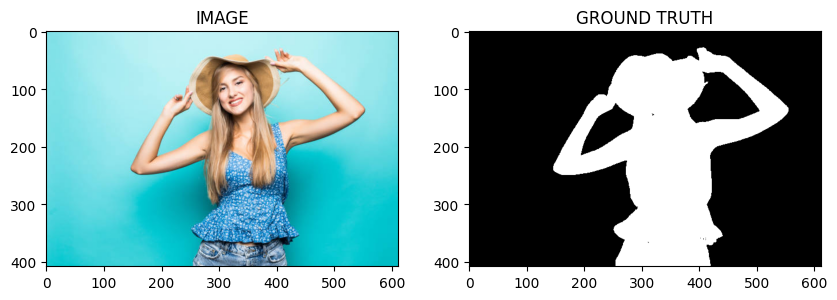

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask, cmap='gray')


# Custom Dataset

In [9]:
train_df, valid_df = train_test_split(df, test_size = 0.2 , random_state=42)

Albumentations

In [18]:
import albumentations as A

def show_image(image, mask):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(np.transpose(image.numpy(), (1, 2, 0)))
    ax[0].set_title('Image')
    ax[1].imshow(mask.numpy()[0], cmap='gray')
    ax[1].set_title('Mask')
    plt.show()

def get_train_augs():
    return A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5)
    ])

def get_valid_augs():
    return A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE)
    ])


In [19]:
from torch.utils.data import Dataset

class SegmentationDataset(Dataset):
    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        image_path = row.images
        mask_path = row.masks

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis=-1)


        if self.augmentations:
            data = self.augmentations(image=image, mask=mask)
            image = data['image']
            mask = data['mask']

        # Transpose image and mask to (C, H, W)
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)
        image = torch.Tensor(image) / 255.0
        mask = torch.round(torch.Tensor(mask) / 255.0)

        return image, mask

In [20]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [21]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


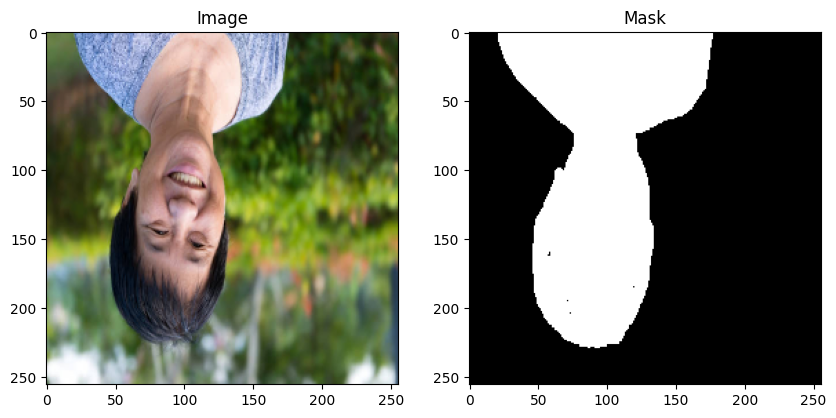

In [22]:
idx = 3
image, mask = trainset[idx]
show_image(image, mask)

Load Dataset into batches - dataloader

In [23]:
from torch.utils.data import DataLoader

In [24]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [25]:
print(f"Total of batches in trainloader : {len(trainloader)}")
print(f"Total of batches in validloader : {len(validloader)}")

Total of batches in trainloader : 15
Total of batches in validloader : 4


In [28]:
for image, mask in trainloader:
    break

print(f'One batch image shape: {image.shape}')
print(f'One batch mask shape: {mask.shape}')


ValueError: Height and Width of image, mask or masks should be equal. You can disable shapes check by setting a parameter is_check_shapes=False of Compose class (do it only if you are sure about your data consistency).